In [1]:
import numpy as np
from numpy import genfromtxt
from itertools import combinations
import torch
import math 
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def angle_btw_hits(arr1,arr2):
    theta1 = arr1[2]
    theta2 = arr2[2]
    phi1 = arr1[3]
    phi2 = arr2[3]
    opang = math.acos(math.sin(theta1)*math.sin(theta2)*math.cos(phi1-phi2)+math.cos(theta1)*math.cos(theta2))
    return opang

In [3]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [4]:
def run_r3b_clustering(data,clustersize):
    print(data.shape)
    array_unique_events = np.unique(data[:,0])
    print(array_unique_events)
    all_pred = []
    for i in range(0,int(np.max(data,axis=0)[0])-(int(np.max(data,axis=0)[0])%3) ,3):
        evt = data[data[:,0] == array_unique_events[i]]
        evt = np.vstack((evt,data[data[:,0] == array_unique_events[i+1]]))
        evt = np.vstack((evt,data[data[:,0] == array_unique_events[i+2]]))
        nr_hits = evt.shape[0]
        hitnr = np.array([x for x in range(evt.shape[0])])
        hitnr = np.transpose(hitnr)
        hitnr = hitnr.reshape(-1, 1)
        evt = np.hstack((evt,hitnr))
        # sort along the energy
        evt = evt[evt[:, 1].argsort()[::-1]]
        #now check opening angle between the hits
        cluster_list = []
        while(evt.shape[0]):
            v_temp = []
            l = []
            for i in range(evt.shape[0]):
                if (i == 0):
                    l.append(evt[0,5].astype(int))
                else:
                    #calculate angle
                    angle = angle_btw_hits(evt[0,:],evt[i,:])
                    if (angle < clustersize):
                        l.append(evt[i,5].astype(int))
                    else:
                        v_temp.append(evt[i,:])
            l.sort()
            cluster_list.append(l)
            evt = np.array(v_temp)
        #compress list of clusters, they need at least two entries to be a cluster, otherwise the single hit is treated as cluster
        compr_cluster_list = []
        for i in range(len(cluster_list)):
            if len(cluster_list[i]) > 1:
                compr_cluster_list.append(cluster_list[i])
            else:
                continue
        final_pair_list = []
        for i in range(len(compr_cluster_list)):
            pair_indices = list(combinations(compr_cluster_list[i],2))
            final_pair_list.append(pair_indices)
        reco_indices = flatten(final_pair_list)
        # compare all combinations with all predicted combinations
        all_combinations = list(combinations(range(nr_hits), 2))
        ## predictions
        pred_list = []
        for i in range(len(all_combinations)):
            pred_value = 0
            for j in range(len(reco_indices)):
                if (all_combinations[i] == reco_indices[j]):
                    #print(type(reco_indices[j]))
                    pred_value = 1
            pred_list.append(pred_value)
            all_pred.append(pred_value)
    return all_pred
        




        

## now method to plot data:

In [5]:
def plot_true_reco(data):
    energy_spec = []
    unique_ind = np.unique(data[:,0])
    for i in unique_ind:
        ene = np.sum(data[data[:,0] == i,1])
        energy_spec.append(ene)

    plt.hist(energy_spec,bins=70,range=(0,7))
    plt.title("True energy spectrum")
    plt.yscale('log')


### in this section I want to get the true values combination list
---

In [6]:
def get_true_combinatorics(data):
    ll = []
    true_vals = []
    for i in range(0,int(np.max(data,axis=0)[0])-(int(np.max(data,axis=0)[0])%3) ,3):
        mask = ((data[:,0] == i) | (data[:,0] == i+1) | (data[:,0] == i+2))
        evt = data[mask]
        pair_indices = list(combinations(range(evt.shape[0]), 2))
        for i, (idx1, idx2) in enumerate(pair_indices):
            l = []
            if (evt[idx1,0] == evt[idx2,0]):
                true_vals.append(1)
            else:
                true_vals.append(0)
    return (true_vals)

---

In [7]:
def get_true_reco_ene(data,reco_vals,true_vals):
    ene_list = []
    ene_true_list = []
    idx = 0
    well_reco = 0
    array_unique_events = np.unique(data[:,0])
    for i in range(0,int(np.max(data,axis=0)[0])-(int(np.max(data,axis=0)[0])%3) ,3):
        mask = ((data[:,0] == i) | (data[:,0] == i+1) | (data[:,0] == i+2))
        evt = data[mask]
        pair_indices = list(combinations(range(evt.shape[0]), 2))
        ##pair indices which belong together...
        pred_comb = []
        ##TJ this is the new part with true stuff
        true_comb = []
        for m in range(evt.shape[0]):
            pred_comb.append((m,m))
            true_comb.append((m,m))
        for j in range (len(pair_indices)):
            if reco_vals[idx+j] > 0.75:
                pred_comb.append(pair_indices[j])
            if true_vals[idx+j] > 0.75:   
                true_comb.append(pair_indices[j])
        G = nx.Graph()
        G.add_edges_from(pred_comb)
        connected_components = list(nx.connected_components(G))
        ##TJ again, this it the addition for the true values
        T = nx.Graph()
        T.add_edges_from(true_comb)
        true_components = list(nx.connected_components(T))
        set_true = {frozenset(sublist) for sublist in true_components}
        set_pred = {frozenset(sublist) for sublist in connected_components}
        # Find the intersection of the two sets
        common_sublists = set_true.intersection(set_pred)
        well_reco += len(common_sublists)
        for k in range(len(connected_components)):
            columns_to_sum = evt[list(connected_components[k]),1]
            ene = np.sum(columns_to_sum)
            ene_list.append(ene)
        #make list true energy
        for l in range(len(true_components)):
            true_columns_to_sum = evt[list(true_components[l]),1]
            ene_true = np.sum(true_columns_to_sum)
            ene_true_list.append(ene_true)
        idx += len(pair_indices)
    single_hit_energies = []
    for i in range(data.shape[0]):
        single_hit_energies.append(data[i,1])
        
    #plt.hist(single_hit_energies,bins=70,range=(0,7),label="single hit energy",color="green",alpha=0.5)    
    plt.hist(ene_list,bins=100,range=(0,10),label="reconstructed energy",color="red",alpha=0.3)
    plt.grid()
    plt.hist(ene_true_list,bins=100,range=(0,10),label="true energies",color="blue",alpha=0.3)
    plt.legend()
    plt.yscale('log')
    well_reco = float(well_reco)/float(np.max(data,axis=0)[0])
    print("well reco...", well_reco)
    return (ene_list,ene_true_list,well_reco)

continuous numbers: [   0    1    1 ... 8857 8857 8858]
(17641, 5)
[0.000e+00 1.000e+00 2.000e+00 ... 8.856e+03 8.857e+03 8.858e+03]
well reco... 0.8692707157371867


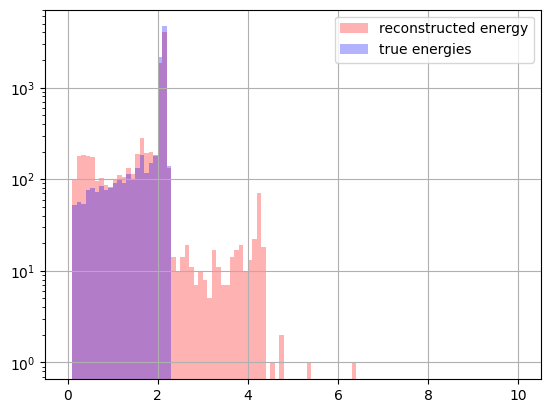

In [8]:
data = genfromtxt('raw_data_test.txt', delimiter=',')
#data = genfromtxt('data_stream_2121.txt', delimiter=',')
#my_data[:,4] = my_data[:,4]+4500  #this step is needed, I only want positive time values, so that I can use the time as a radius
data[:,4] = 1  #this step is needed, I only want positive time values, so that I can use the time as a radius
# ### structure of mydata : eventnr, energy, theta, phi, hit-time
data = data*[1.,1.,3.14159/180,3.14159/180,1.]
unique_values, continuous_numbers = np.unique(data[:,0], return_inverse=True)
data[:,0] = continuous_numbers
print("continuous numbers:", continuous_numbers)
out_cluster_r3b = run_r3b_clustering(data,0.25)
#foo = plot_true_reco(data)
foo_comb = get_true_combinatorics(data)
foo_ene = get_true_reco_ene(data,out_cluster_r3b,foo_comb)

